# Model Evaluation Results

This notebook compares the performance of different transformer models for emotion classification. Models are evaluated based on their F1 scores and accuracy metrics. DistilBERT is used as the baseline model.

## Import Libraries

In [33]:
%pip install -q pandas matplotlib seaborn

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path

REPO_ROOT = Path().resolve().parent

Note: you may need to restart the kernel to use updated packages.


## Load Metrics

In [34]:
ARTIFACT_ROOT = REPO_ROOT / "ml" / "artifacts"

runs = [
    ARTIFACT_ROOT / "distilbert_v1",
    ARTIFACT_ROOT / "minilm_v1",
]

In [35]:
rows = []

for run in runs:
    metrics_path = run / "test_metrics.json"
    if not metrics_path.exists():
        print(f"Missing metrics for {run}")
        continue

    with open(metrics_path) as f:
        metrics = json.load(f)

    rows.append(metrics)

df = pd.DataFrame(rows)
df

,model,config,timestamp,accuracy,macro_f1,micro_f1,weighted_f1,per_class_precision,per_class_recall,per_class_f1,per_class_support,confusion_matrix,label_names
0,distilbert-base-uncased,distilbert.yaml,2025-12-21T21:36:38.602174,0.9285,0.888840,0.9285,0.928686,"[0.9622641509433962, 0.9445234708392604, 0.863...","[0.9655765920826161, 0.9553956834532374, 0.798...","[0.9639175257731959, 0.949928469241774, 0.8300...","[581, 695, 159, 275, 224, 66]","[[561, 5, 0, 11, 4, 0], [2, 664, 20, 2, 0, 7],...","[sadness, joy, love, anger, fear, surprise]"
1,microsoft/MiniLM-L12-H384-uncased,minilm.yaml,2025-12-21T21:36:22.526037,0.9115,0.860903,0.9115,0.912126,"[0.9521367521367521, 0.9434782608695652, 0.772...","[0.9586919104991394, 0.9366906474820144, 0.855...","[0.9554030874785592, 0.940072202166065, 0.8119...","[581, 695, 159, 275, 224, 66]","[[557, 7, 2, 8, 7, 0], [3, 651, 37, 3, 1, 0], ...","[sadness, joy, love, anger, fear, surprise]"


 ## Clean & Sort Metrics

In [36]:
display_cols = [
    "model",
    "config",
    "accuracy",
    "macro_f1",
    "micro_f1",
    "weighted_f1",
]

df_sorted = (
    df[display_cols]
    .sort_values("macro_f1", ascending=False)
    .reset_index(drop=True)
)

df_sorted

,model,config,accuracy,macro_f1,micro_f1,weighted_f1
0,distilbert-base-uncased,distilbert.yaml,0.9285,0.888840,0.9285,0.928686
1,microsoft/MiniLM-L12-H384-uncased,minilm.yaml,0.9115,0.860903,0.9115,0.912126


## Per-Class Performance Comparison

In [37]:
# Create per-class comparison dataframes
for _, row in df.iterrows():
    model_name = row['model'].split('/')[-1]
    print(f"Per-Class Metrics: {model_name}")
    
    label_names = row.get('label_names')
    precision = row.get('per_class_precision')
    recall = row.get('per_class_recall')
    f1 = row.get('per_class_f1')
    support = row.get('per_class_support')
    
    per_class_df = pd.DataFrame({
        'Emotion': label_names,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Support': support
    })
    
    # Display it pretty
    display(per_class_df.style.format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1': '{:.4f}',
        'Support': '{:.0f}'
    }).background_gradient(subset=['F1'], cmap='Blues', vmin=0.7, vmax=1.0))

Per-Class Metrics: distilbert-base-uncased


,Emotion,Precision,Recall,F1,Support
0,sadness,0.9623,0.9656,0.9639,581
1,joy,0.9445,0.9554,0.9499,695
2,love,0.8639,0.7987,0.8301,159
3,anger,0.9307,0.9273,0.9290,275
4,fear,0.9187,0.8571,0.8868,224
5,surprise,0.6905,0.8788,0.7733,66


Per-Class Metrics: MiniLM-L12-H384-uncased


,Emotion,Precision,Recall,F1,Support
0,sadness,0.9521,0.9587,0.9554,581
1,joy,0.9435,0.9367,0.9401,695
2,love,0.7727,0.8553,0.8119,159
3,anger,0.9305,0.8764,0.9026,275
4,fear,0.8716,0.8482,0.8597,224
5,surprise,0.6667,0.7273,0.6957,66


## Confusion Matrices

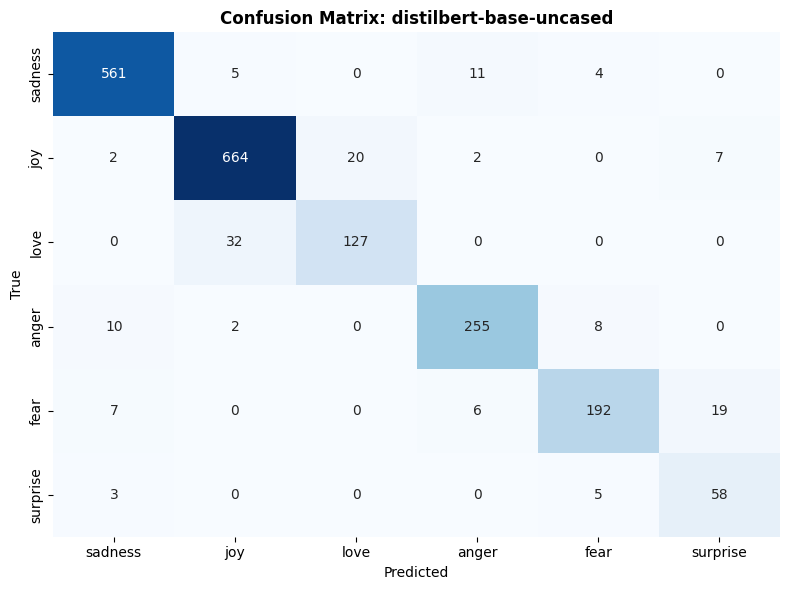

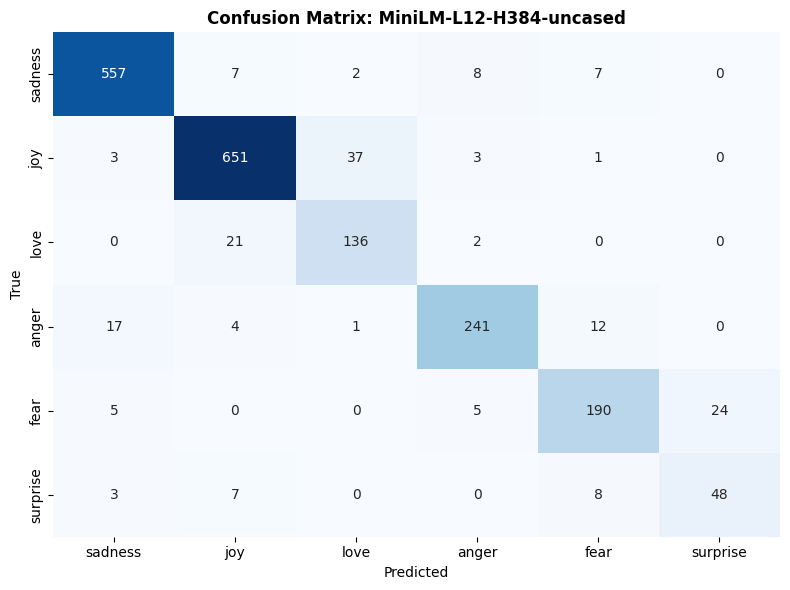

In [38]:
for _, row in df.iterrows():
    model_name = row['model'].split('/')[-1]
    confusion_matrix = np.array(row["confusion_matrix"])
    label_names = row.get('label_names', [])
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=label_names,
        yticklabels=label_names,
        cbar_kws={'label': 'Count'},
        cbar=False
    )
    plt.title(f'Confusion Matrix: {model_name}', fontsize=12, fontweight='bold')
    plt.ylabel('True', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.tight_layout()
    plt.show()


## Insights

DistilBERT outperforms MiniLM across all evaluation metrics:
- **Accuracy**: 1.70% improvement (92.85% vs 91.15%)
- **Macro F1**: 2.8% improvement (0.8888 vs 0.8609)

**Per-Class Differences:**
- DistilBERT performs better on high-frequency emotions.
- MiniLM shows higher recall on some low-support classes but with lower precision, resulting in worse F1 scores on minority classes overall.
- Both models struggle most with low-support classes, reflecting the dataset's class imbalance.

DistilBERT is the better choice, offering better balanced performance across classes while maintaining higher overall accuracy.